# Finetune ResNet50


With 224x224 melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
FINETUNED_MODEL = 'resnet50_224'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.resnet50(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [14]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 20

C:\Users\profi\AppData\Local\Temp\ipykernel_30884\29953048.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/20


Validating: 100%|██████████| 75/75 [00:10<00:00,  7.12it/s, Loss=1.6561157703399658, Elapsed=21.5392s, ETA=0.0000s] 


Epoch 1 completed in 77.3899s
Train Loss: 1.4490292902626742 - Train Accuracy: 41.231541575269674
Validation Loss: 1.3101586119333903 - Validation Accuracy: 44.94512452511608

Epoch 2/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.19it/s, Loss=1.7279070615768433, Elapsed=20.0473s, ETA=0.0000s] 


Epoch 2 completed in 72.1867s
Train Loss: 1.2784635100750565 - Train Accuracy: 46.649781777888336
Validation Loss: 1.2744632037480672 - Validation Accuracy: 47.066272688898266

Epoch 3/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.22it/s, Loss=1.3767105340957642, Elapsed=20.1218s, ETA=0.0000s] 


Epoch 3 completed in 72.1317s
Train Loss: 1.2317622028334292 - Train Accuracy: 48.24404694602112
Validation Loss: 1.2721018425623576 - Validation Accuracy: 45.947657239341495

Epoch 4/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.09it/s, Loss=1.459924340248108, Elapsed=20.2509s, ETA=0.0000s]  


Epoch 4 completed in 72.1556s
Train Loss: 1.2010037011838373 - Train Accuracy: 49.24131068949142
Validation Loss: 1.2027051544189453 - Validation Accuracy: 50.042211903756865

Epoch 5/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.12it/s, Loss=1.3367716073989868, Elapsed=20.0537s, ETA=0.0000s] 


Epoch 5 completed in 71.8805s
Train Loss: 1.1862055335430741 - Train Accuracy: 49.603129734741415
Validation Loss: 1.2093687224388123 - Validation Accuracy: 48.37484170536091

Epoch 6/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.99it/s, Loss=1.372030258178711, Elapsed=20.7764s, ETA=0.0000s]  


Epoch 6 completed in 73.1078s
Train Loss: 1.1727373927314846 - Train Accuracy: 49.955903303860154
Validation Loss: 1.1870500882466635 - Validation Accuracy: 49.39848037146476

Epoch 7/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.00it/s, Loss=1.2543258666992188, Elapsed=20.3128s, ETA=0.0000s] 


Epoch 7 completed in 72.7213s
Train Loss: 1.1548024696766297 - Train Accuracy: 50.8694963931164
Validation Loss: 1.2462739070256552 - Validation Accuracy: 49.63064584212748

Epoch 8/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.20it/s, Loss=1.0029115676879883, Elapsed=20.1075s, ETA=0.0000s] 


Epoch 8 completed in 72.3386s
Train Loss: 1.147004460840556 - Train Accuracy: 51.088849189299204
Validation Loss: 1.1993020192782085 - Validation Accuracy: 47.10848459265513

Epoch 9/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.12it/s, Loss=1.2970212697982788, Elapsed=20.2400s, ETA=0.0000s] 


Epoch 9 completed in 72.1665s
Train Loss: 1.1316814801596493 - Train Accuracy: 51.94816942176794
Validation Loss: 1.1758740441004436 - Validation Accuracy: 47.67834529337273

Epoch 10/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.05it/s, Loss=1.1918582916259766, Elapsed=20.1857s, ETA=0.0000s] 


Epoch 10 completed in 72.2692s
Train Loss: 1.1289090512460367 - Train Accuracy: 52.17204495601637
Validation Loss: 1.1614465133349101 - Validation Accuracy: 49.75728155339806

Epoch 11/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.09it/s, Loss=1.021626353263855, Elapsed=20.4047s, ETA=0.0000s]  


Epoch 11 completed in 73.0030s
Train Loss: 1.1215507289922306 - Train Accuracy: 52.24214739603356
Validation Loss: 1.2869746081034343 - Validation Accuracy: 46.538623891937526

Epoch 12/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.14it/s, Loss=1.4285590648651123, Elapsed=20.2158s, ETA=0.0000s] 


Epoch 12 completed in 72.6985s
Train Loss: 1.105243869255044 - Train Accuracy: 52.877592094253856
Validation Loss: 1.1531205328305563 - Validation Accuracy: 53.6935415787252

Epoch 13/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.08it/s, Loss=1.3115711212158203, Elapsed=20.5268s, ETA=0.0000s] 


Epoch 13 completed in 73.0487s
Train Loss: 1.1013813008462763 - Train Accuracy: 52.83236471359761
Validation Loss: 1.173441418806712 - Validation Accuracy: 50.348248205994096

Epoch 14/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.14it/s, Loss=1.0113439559936523, Elapsed=20.2168s, ETA=0.0000s] 


Epoch 14 completed in 72.7013s
Train Loss: 1.0988371830455141 - Train Accuracy: 53.15800185432261
Validation Loss: 1.1426837714513143 - Validation Accuracy: 51.53018151118616

Epoch 15/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.15it/s, Loss=1.1477669477462769, Elapsed=20.0975s, ETA=0.0000s] 


Epoch 15 completed in 72.7846s
Train Loss: 1.0822043282792748 - Train Accuracy: 53.33891137694761
Validation Loss: 1.136753036181132 - Validation Accuracy: 51.150274377374416

Epoch 16/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.12it/s, Loss=1.1921122074127197, Elapsed=20.2786s, ETA=0.0000s] 


Epoch 16 completed in 72.6886s
Train Loss: 1.0871970681096776 - Train Accuracy: 53.25976346079917
Validation Loss: 1.152343787352244 - Validation Accuracy: 53.75685943436049

Epoch 17/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.96it/s, Loss=1.2068448066711426, Elapsed=20.2625s, ETA=0.0000s] 


Epoch 17 completed in 72.9627s
Train Loss: 1.0706979711620794 - Train Accuracy: 54.15074285972727
Validation Loss: 1.121244413057963 - Validation Accuracy: 52.152807091599826

Epoch 18/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.15it/s, Loss=1.2241560220718384, Elapsed=20.3005s, ETA=0.0000s] 


Epoch 18 completed in 72.7323s
Train Loss: 1.0695070779392486 - Train Accuracy: 54.17109518102259
Validation Loss: 1.119104106426239 - Validation Accuracy: 54.85436893203883

Epoch 19/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.97it/s, Loss=1.353410243988037, Elapsed=20.2660s, ETA=0.0000s]  


Epoch 19 completed in 72.7157s
Train Loss: 1.0595833760810036 - Train Accuracy: 54.29547047782728
Validation Loss: 1.162675790786743 - Validation Accuracy: 54.653862389193755

Epoch 20/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.96it/s, Loss=1.4632129669189453, Elapsed=22.0710s, ETA=0.0000s] 

Epoch 20 completed in 74.9688s
Train Loss: 1.0614373487544198 - Train Accuracy: 54.32939101331946
Validation Loss: 1.1365654222170511 - Validation Accuracy: 53.957365977205576



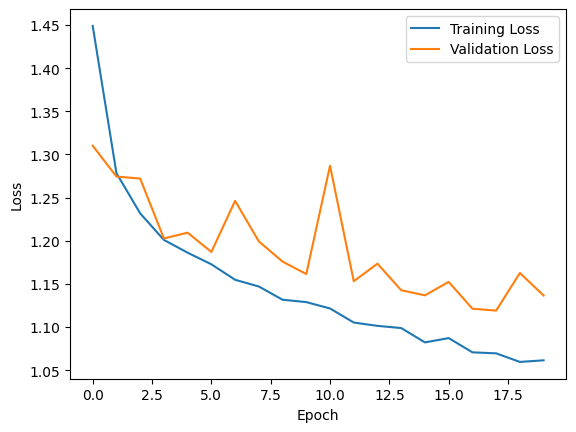

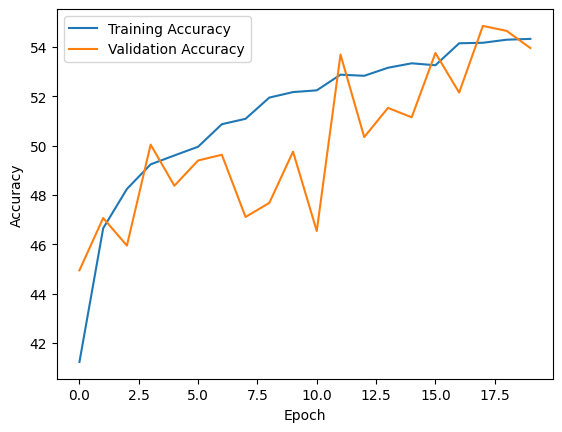

In [15]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evalaute best model on test set


In [17]:
def get_predictions(model, testloader, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    print("Evaluating best model on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

Define the function to print out the evaluation metrics


In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


def get_evaluation_metrics(true_labels, pred_labels, label_map):
    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}\n")

    # Print detailed classification report
    print(classification_report(true_labels, pred_labels,
          target_names=list(label_map.keys())))

Evaluate the best model on the test set


C:\Users\profi\AppData\Local\Temp\ipykernel_30884\3256607076.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:22<00:00,  3.39it/s]

Test Accuracy: 0.5412
Test Precision: 0.5565
Test Recall: 0.5412
Test F1-score: 0.5328

              precision    recall  f1-score   support

       Anger       0.51      0.54      0.52       916
       Bored       0.63      0.84      0.72      1098
     Disgust       0.27      0.65      0.38       291
        Fear       0.36      0.57      0.44       308
       Happy       0.55      0.44      0.49      1914
     Neutral       0.59      0.33      0.42      2226
    Question       0.62      0.74      0.67      1139
         Sad       0.55      0.57      0.56       857
    Surprise       0.54      0.63      0.58       728

    accuracy                           0.54      9477
   macro avg       0.51      0.59      0.53      9477
weighted avg       0.56      0.54      0.53      9477



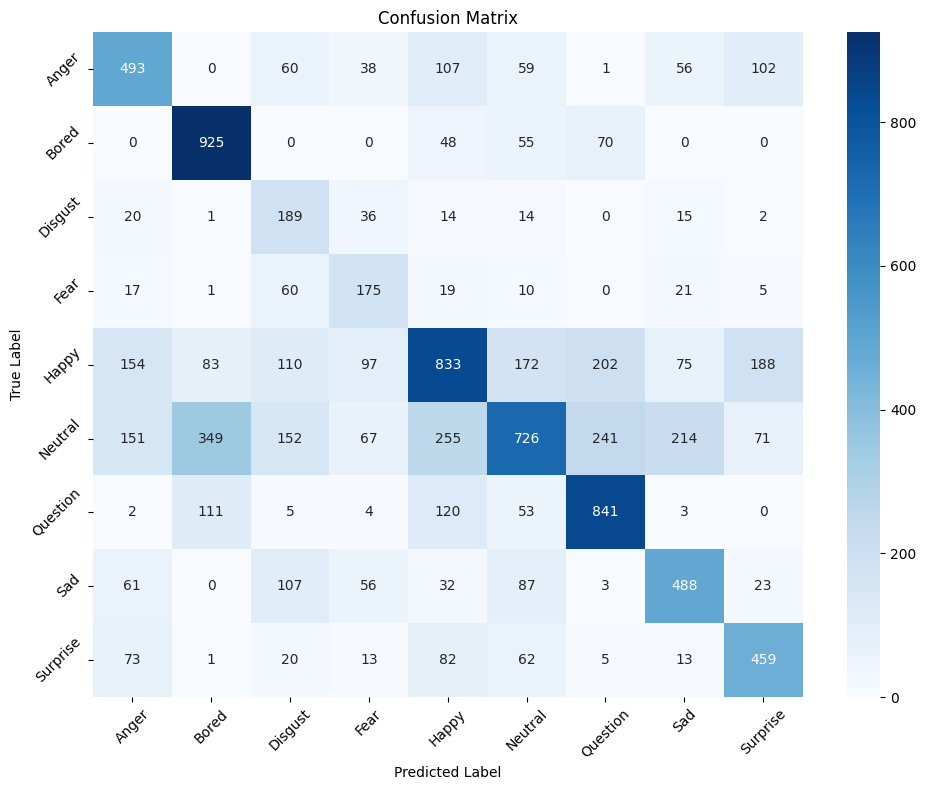

In [20]:
# Load and get predictions from the bets model
best_model_path = f'best_{FINETUNED_MODEL}.pt'
all_preds, all_labels = get_predictions(
    model=model,
    testloader=testloader,
    device=device,
    model_path=best_model_path
)

# Print detailed evaluation metrics
get_evaluation_metrics(all_labels, all_preds, labelmap)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)